# TIGER nnUnet BatchIterator

In [9]:
## Install latests wholeslidedata
# !pip3 install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main
# !pip3 install lxml

In [10]:
import os
import requests
import yaml
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm

if os.name == 'nt':
    os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from wholeslidedata import WholeSlideImage, WholeSlideAnnotation
from wholeslidedata.interoperability.nnunet.iterator import WholeSlidePlainnnUnetBatchIterator

# This allows for creating a user config with yaml syntax in a notebook cell
from dicfg.magics import ConfigMagics
ConfigMagics.register_magics()

In [11]:
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"

def convert_path(path, to=current_os):
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path

# Table of contents 

1. **User Config**
    - An example user config is give which will be used to configure the batch iterator
2. **BatchIterator**
    - A  BatchIterator is created and some batches are plotted
3. **WholeSlidePlainnnUnetBatchIterator**
    - An example is given how to use the WholeSlidePlainnnUnetBatchIterator to be used in the nnUnet training pipeline
4. **Proposal implementation BatchIterator in nnUNetTrainer**
    - An example **(not tested)** of how the batchiterator **might** can be implemented in the nnUnetTrainer

## 1. **User Config**
- The following yaml will be saved as a dict in 'user_config' with the magic %%yaml                                
- Alternatively, the yaml could be saved in an external user_config.yml file
- Note that this configuration depends on external yaml files: tigersegmentationblissey.yml and augmentations.yml
- Documentation about the syntax in this config can be found here: [dicfg](https://martvanrijthoven.github.io/dicfg/)

**Please check all settings, e.g., the weights in the label sampler, and the augmentations.yml, if they are sensible.**


### 1.1 files yaml

In [12]:
r = requests.get('https://raw.githubusercontent.com/DIAGNijmegen/pathology-whole-slide-data/main/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml')
files_yml = yaml.safe_load(r.text)
first_n_samples = 4
replace_path = '/data/pathology/projects/tiger/new_structure/training/wsirois'
example_files = {'training':files_yml['training'][0:first_n_samples]}
for entry in example_files['training']:
    entry['wsa']['path'] = convert_path(entry['wsa']['path'].replace('/home/user', replace_path))
    entry['wsi']['path'] = convert_path(entry['wsi']['path'].replace('/home/user', replace_path))
example_files

{'training': [{'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\100B.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\100B.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\114S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\114S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\122S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\122S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\133S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\w

# Do splits

In [13]:
# from wholeslidedata.data.dataset import WholeSlideDataSet
# from wholeslidedata.data.mode import WholeSlideMode
from wholeslidedata import WholeSlideAnnotation
# from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.asap.parser import AsapAnnotationParser
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from wholeslidedata.annotation.selector import sort_by_area_with_roi
from shapely.ops import unary_union
from shapely import Point
from collections import Counter

In [14]:
def get_closest_spacing(spacing_value):
    possible_spacings = [0.25, 0.5, 1, 2, 4, 8, 16]
    closest = min(possible_spacings, key=lambda x:abs(x-spacing_value))
    return closest

In [101]:
labels = {
    "roi": 0, # in case 0 is true background instead of unannotated, make sure you add it as label 1, not 0. Since label 0 will not be used for counting
    "invasive tumor": 1,
    "tumor-associated stroma": 2,
    "in-situ tumor": 3 ,
    "healthy glands": 4,
    "necrosis not in-situ": 5,
    "inflamed stroma": 6,
    "rest": 7
}
# count_labels = {k : v+1 for k, v in labels.items()}
count_mask_labels = ['roi'] # or empty list
assert isinstance(count_mask_labels, list), 'not a list'


count_mask_labels = {label: 1 for label in count_mask_labels} # will make mask with 0 and 1 values
label_sampler = SegmentationPatchLabelSampler()
parser = AsapAnnotationParser(labels=labels, sample_label_names=['roi'], sorters=[sort_by_area_with_roi])
# count_parser = AsapAnnotationParser(labels=count_labels, sample_label_names=['roi'], sorters=[sort_by_area_with_roi])
count_mask_parser = AsapAnnotationParser(labels=count_mask_labels, sorters=[sort_by_area_with_roi])

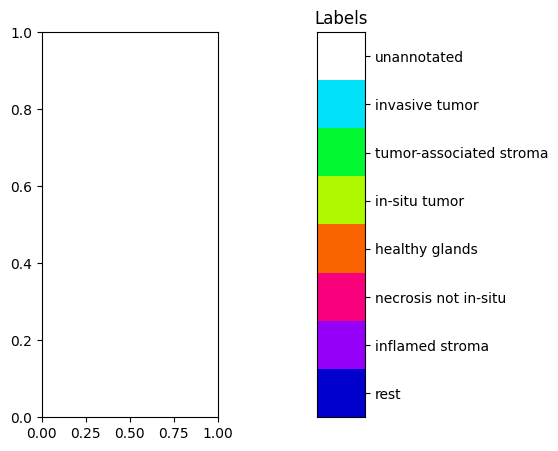

In [15]:
# import pylab as plt

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['unannotated'] + list(labels.keys())[1:]
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}


%matplotlib inline

# left is meant to be empty. its just easy to copy paste in figures this way
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[-1].imshow([[i] for i in list(range(len(label_names)))], **label_plot_args)
axs[-1].set_yticks(label_index)
axs[-1].set_yticklabels(label_names)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

In [16]:
for entry in files_yml['training']:
    entry['wsa']['path'] = convert_path(entry['wsa']['path'].replace('/home/user', replace_path))
    entry['wsi']['path'] = convert_path(entry['wsi']['path'].replace('/home/user', replace_path))

In [17]:
def get_pixel_counts(array, label_dict):
    counter = Counter(array.flatten())
    counts = [counter[value] for value in label_dict.values()]
    return counts

In [18]:
def plot_percentages(counts, title):
    sum_total = sum(counts)
    percentages = [round((count/sum_total)*100,1) for count in counts]
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    fig.suptitle(title, fontsize=15)
    bar_list = axs.barh(label_names, percentages, height=1) #, height=0.95, log=True)
    for i, bar in enumerate(bar_list):
        bar.set_color(cmap(label_index[i]))
        bar.set_edgecolor("black")
    axs.invert_yaxis()
    axs.set_title("Percentage of total per label")
    for i in range(n_labels):
        plt.text(percentages[i], i, s=" " + str(percentages[i]), 
                 ha="left", va="center")
    axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
    plt.tight_layout()
    plt.show()
    # return fig, axs

In [112]:
# if not count_mask_labels:
#     all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_wsa.annotations])
#     all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_wsa.annotations])
#     x_min, x_max = all_x_coords.min(), all_x_coords.max()
#     y_min, y_max = all_y_coords.min(), all_y_coords.max()
#     centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
# else:
#     all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_mask_wsa.annotations])
#     all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_mask_wsa.annotations])
#     x_min, x_max = all_x_coords.min(), all_x_coords.max()
#     y_min, y_max = all_y_coords.min(), all_y_coords.max()

# centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
# shape = (int((x_max - x_min)/sample_ratio), int((y_max - y_min)/sample_ratio))

In [ ]:
wsi.

In [115]:
shape

(565, 1354)

In [103]:
sample_ratio

16.0

In [105]:
x_shape = (x_max - x_min)/sample_ratio
y_shape = (y_max - y_min)/sample_ratio

565.25

In [102]:
shape

(8504, 9192)

In [99]:
x_min, x_max ,y_min, y_max

(34454.0, 43498.0, 44415.0, 66093.0)

In [116]:
label_mask = label_sampler.sample(count_wsa, centroid, (600, 1400), ratio=sample_ratio)

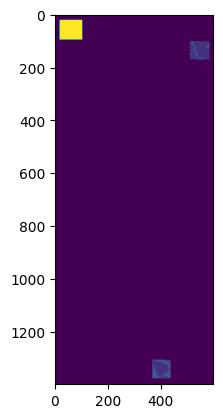

In [117]:
plt.imshow(label_mask)

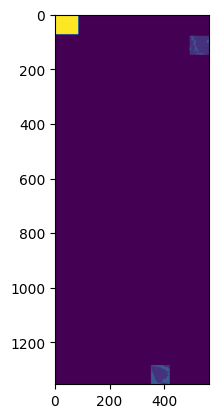

In [114]:
plt.imshow(label_mask)

In [120]:
import time

In [122]:
do_time = False

In [177]:
start_time = time.time()
sample_spacing = 2 #0.5
counts_df_path = convert_path(f'train_set_label_pixel_counts_get_slide_{sample_spacing}_minmax.csv')
overwrite = False

if not os.path.isfile(counts_df_path) or overwrite == True:   
    count_data = []
    for idx_sample, sample in enumerate(files_yml['training']):
        
        # Get whole slide annotations
       

        if do_time:
            start_time = time.time()
        wsa_path = sample['wsa']['path']
        count_wsa = WholeSlideAnnotation(wsa_path, parser=parser)
        if count_mask_labels:
            count_mask_wsa = WholeSlideAnnotation(wsa_path, parser=count_mask_parser)

        # Get whole slide image
        wsi_path = sample['wsi']['path']
        wsi = WholeSlideImage(wsi_path, backend='asap')
        stem = Path(wsi_path).stem
        print(f"{idx_sample+1}/{len(files_yml['training'])}:", stem)

        wsi_spacing0 = wsi.spacings[0]
        sample_ratio = sample_spacing / get_closest_spacing(wsi_spacing0) 
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tWSI WSA: {execution_time} seconds")
            start_time = time.time()
        
        # Get centroid and shape to count label pixels in
        if not count_mask_labels:
            # min and max from all coordinates
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
            centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        else:
            # min and max from mask coordinates only
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_mask_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_mask_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
        centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        shape = (int((x_max - x_min)/sample_ratio), int((y_max - y_min)/sample_ratio))
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tcentroid and shape: {execution_time} seconds")
            start_time = time.time()
        
        # get the label mask
        label_mask = label_sampler.sample(count_wsa, centroid, shape, ratio=sample_ratio)
        if count_mask_labels:
            # get the count mask which defines the regions we want to count the labels in (everything outside is excluded from counting)
            count_mask = label_sampler.sample(count_mask_wsa, centroid, shape, ratio=sample_ratio)
            count_label_mask = label_mask.flatten()[count_mask.flatten().astype('bool')] #only keep counts in mask
        else: 
            count_label_mask = label_mask
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tlabel and count mask: {execution_time} seconds")
            start_time = time.time()
        
        counts = get_pixel_counts(count_label_mask, labels)

        add_data = [stem] + counts + [wsi_path, wsa_path]
        count_data.append(add_data)
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"/tcounting: {execution_time} seconds")
            start_time = time.time()
        
        # break
#         for idx_roi, roi in enumerate(wsa.sampling_annotations):
#             label_mask = label_sampler.sample(wsa, roi.centroid, roi.size, ratio=sample_ratio) 

#             counter = Counter(label_mask.flatten())
#             counts = [counter[value] for value in labels.values()]

#             add_data = [stem, idx_roi] + counts + [wsi_path, wsa_path]
#             count_data.append(add_data)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\tTOTAL: {execution_time} seconds")
else:
    print('already got counts data') 


already got counts data


In [207]:
do_time = True
total_start_time = time.time()
sample_spacing = 4 #0.5
counts_df_path = convert_path(f'train_set_label_pixel_counts_get_slide_{sample_spacing}_minmax.csv')
overwrite = True

if not os.path.isfile(counts_df_path) or overwrite == True:   
    count_data = []
    for idx_sample, sample in enumerate(files_yml['training']):
        
        # Get whole slide annotations
        if do_time:
            start_time = time.time()
        wsa_path = sample['wsa']['path']
        count_wsa = WholeSlideAnnotation(wsa_path, parser=parser)
        if count_mask_labels:
            count_mask_wsa = WholeSlideAnnotation(wsa_path, parser=count_mask_parser)

        # Get whole slide image
        wsi_path = sample['wsi']['path']
        wsi = WholeSlideImage(wsi_path, backend='asap')
        stem = Path(wsi_path).stem
        print(f"{idx_sample+1}/{len(files_yml['training'])}:", stem)

        wsi_spacing0 = wsi.spacings[0]
        sample_ratio = sample_spacing / get_closest_spacing(wsi_spacing0) 
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tWSI WSA: {execution_time} seconds")
            start_time = time.time()
        
        # Get centroid and shape to count label pixels in
        if not count_mask_labels:
            # min and max from all coordinates
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
            centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        else:
            # min and max from mask coordinates only
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_mask_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_mask_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
        centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        shape = (int((x_max - x_min)/sample_ratio), int((y_max - y_min)/sample_ratio))
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tcentroid and shape: {execution_time} seconds")
            start_time = time.time()
        
        # get the label mask
        label_mask = label_sampler.sample(count_wsa, centroid, shape, ratio=sample_ratio)
        if count_mask_labels:
            # get the count mask which defines the regions we want to count the labels in (everything outside is excluded from counting)
            count_mask = label_sampler.sample(count_mask_wsa, centroid, shape, ratio=sample_ratio)
            count_label_mask = label_mask.flatten()[count_mask.flatten().astype('bool')] #only keep counts in mask
        else: 
            count_label_mask = label_mask
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tlabel and count mask: {execution_time} seconds")
            start_time = time.time()
        
        counts = get_pixel_counts(count_label_mask, labels)

        add_data = [stem] + counts + [wsi_path, wsa_path]
        count_data.append(add_data)
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tcounting: {execution_time} seconds")
            start_time = time.time()
        
        # break
#         for idx_roi, roi in enumerate(wsa.sampling_annotations):
#             label_mask = label_sampler.sample(wsa, roi.centroid, roi.size, ratio=sample_ratio) 

#             counter = Counter(label_mask.flatten())
#             counts = [counter[value] for value in labels.values()]

#             add_data = [stem, idx_roi] + counts + [wsi_path, wsa_path]
#             count_data.append(add_data)
    total_end_time = time.time()
    execution_time = total_end_time - total_start_time
    print(f"\tTOTAL: {execution_time} seconds")
else:
    print('already got counts data') 


1/195: 100B
	WSI WSA: 2.512604236602783 seconds
	centroid and shape: 0.0020029544830322266 seconds
	label and count mask: 0.37830424308776855 seconds
	counting: 0.005472660064697266 seconds
2/195: 114S
	WSI WSA: 2.604384422302246 seconds
	centroid and shape: 0.0 seconds
	label and count mask: 0.5300426483154297 seconds
	counting: 0.00499272346496582 seconds
3/195: 122S
	WSI WSA: 3.4619669914245605 seconds
	centroid and shape: 0.0009980201721191406 seconds
	label and count mask: 0.5645818710327148 seconds
	counting: 0.004993915557861328 seconds
4/195: 133S
	WSI WSA: 2.5493810176849365 seconds
	centroid and shape: 0.0 seconds
	label and count mask: 1.4442317485809326 seconds
	counting: 0.004984617233276367 seconds
5/195: 134B
	WSI WSA: 2.6337406635284424 seconds
	centroid and shape: 0.0 seconds
	label and count mask: 0.5641059875488281 seconds
	counting: 0.004997730255126953 seconds
6/195: 136B
	WSI WSA: 2.499607801437378 seconds
	centroid and shape: 0.0010325908660888672 seconds
	label 

KeyboardInterrupt: 

In [179]:
start_time = time.time()
sample_spacing = 8 #0.5
counts_df_path = convert_path(f'train_set_label_pixel_counts_get_slide_{sample_spacing}_minmax.csv')
overwrite = False

if not os.path.isfile(counts_df_path) or overwrite == True:   
    count_data = []
    for idx_sample, sample in enumerate(files_yml['training']):
        
        # Get whole slide annotations
       

        if do_time:
            start_time = time.time()
        wsa_path = sample['wsa']['path']
        count_wsa = WholeSlideAnnotation(wsa_path, parser=parser)
        if count_mask_labels:
            count_mask_wsa = WholeSlideAnnotation(wsa_path, parser=count_mask_parser)

        # Get whole slide image
        wsi_path = sample['wsi']['path']
        wsi = WholeSlideImage(wsi_path, backend='asap')
        stem = Path(wsi_path).stem
        print(f"{idx_sample+1}/{len(files_yml['training'])}:", stem)

        wsi_spacing0 = wsi.spacings[0]
        sample_ratio = sample_spacing / get_closest_spacing(wsi_spacing0) 
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tWSI WSA: {execution_time} seconds")
            start_time = time.time()
        
        # Get centroid and shape to count label pixels in
        if not count_mask_labels:
            # min and max from all coordinates
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
            centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        else:
            # min and max from mask coordinates only
            all_x_coords = np.hstack([anno.coordinates[:, 0] for anno in count_mask_wsa.annotations])
            all_y_coords = np.hstack([anno.coordinates[:, 1] for anno in count_mask_wsa.annotations])
            x_min, x_max = all_x_coords.min(), all_x_coords.max()
            y_min, y_max = all_y_coords.min(), all_y_coords.max()
        centroid = (np.mean([x_min, x_max]), np.mean([y_min, y_max]))
        shape = (int((x_max - x_min)/sample_ratio), int((y_max - y_min)/sample_ratio))
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tcentroid and shape: {execution_time} seconds")
            start_time = time.time()
        
        # get the label mask
        label_mask = label_sampler.sample(count_wsa, centroid, shape, ratio=sample_ratio)
        if count_mask_labels:
            # get the count mask which defines the regions we want to count the labels in (everything outside is excluded from counting)
            count_mask = label_sampler.sample(count_mask_wsa, centroid, shape, ratio=sample_ratio)
            count_label_mask = label_mask.flatten()[count_mask.flatten().astype('bool')] #only keep counts in mask
        else: 
            count_label_mask = label_mask
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\tlabel and count mask: {execution_time} seconds")
            start_time = time.time()
        
        counts = get_pixel_counts(count_label_mask, labels)

        add_data = [stem] + counts + [wsi_path, wsa_path]
        count_data.append(add_data)
        
        if do_time:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"/tcounting: {execution_time} seconds")
            start_time = time.time()
        
        # break
#         for idx_roi, roi in enumerate(wsa.sampling_annotations):
#             label_mask = label_sampler.sample(wsa, roi.centroid, roi.size, ratio=sample_ratio) 

#             counter = Counter(label_mask.flatten())
#             counts = [counter[value] for value in labels.values()]

#             add_data = [stem, idx_roi] + counts + [wsi_path, wsa_path]
#             count_data.append(add_data)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\tTOTAL: {execution_time} seconds")
else:
    print('already got counts data') 


already got counts data


In [181]:
if not os.path.isfile(counts_df_path) or overwrite == True:
    df_counts = pd.DataFrame(count_data, columns=['wsi'] + label_names + ['wsi_path', 'wsa_path'])
    df_counts.to_csv(counts_df_path, index=False)
    display(df_counts.head())
else:
    df_counts = pd.read_csv(counts_df_path)
    display(df_counts.head())

,wsi,unannotated,invasive tumor,tumor-associated stroma,in-situ tumor,healthy glands,necrosis not in-situ,inflamed stroma,rest,wsi_path,wsa_path
0,100B,163,14343,9633,0,14490,0,0,35696,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
1,114S,16,18349,15113,0,9602,0,2405,19727,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
2,122S,196,23325,10988,0,0,8574,0,21605,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
3,133S,0,14513,28977,0,0,0,0,21315,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
4,134B,315,15361,30810,0,0,0,1059,24300,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...


In [182]:
if not os.path.isfile(counts_df_path) or overwrite == True:
    df_counts = pd.DataFrame(count_data, columns=['wsi'] + label_names + ['wsi_path', 'wsa_path'])
    df_counts.to_csv(counts_df_path, index=False)
    display(df_counts.head())
else:
    df_counts = pd.read_csv(counts_df_path)
    display(df_counts.head())

,wsi,unannotated,invasive tumor,tumor-associated stroma,in-situ tumor,healthy glands,necrosis not in-situ,inflamed stroma,rest,wsi_path,wsa_path
0,100B,163,14343,9633,0,14490,0,0,35696,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
1,114S,16,18349,15113,0,9602,0,2405,19727,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
2,122S,196,23325,10988,0,0,8574,0,21605,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
3,133S,0,14513,28977,0,0,0,0,21315,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...
4,134B,315,15361,30810,0,0,0,1059,24300,Z:\projects\tiger\new_structure\training\wsiro...,Z:\projects\tiger\new_structure\training\wsiro...


In [183]:
df_counts.groupby(['wsi']).size()

wsi
100B                         1
114S                         1
122S                         1
133S                         1
134B                         1
                            ..
TC_S01_P000145_C0001_B102    1
TC_S01_P000147_C0001_B104    1
TC_S01_P000158_C0001_B101    1
TC_S01_P000159_C0001_B108    1
TC_S01_P000183_C0001_B101    1
Length: 195, dtype: int64

In [184]:
# df_wsi_counts = df_counts[['wsi'] + label_names].groupby('wsi').sum()
# df_wsi_counts = df_wsi_counts.reset_index()

df_wsi_counts = df_counts

In [185]:
# df_counts['wsi_roi_stem'] = df_counts['wsi'].astype(str) + '_ROI' + df_counts['roi'].astype(str)

In [186]:
def plot_counts(counts, title):
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(title, fontsize=15)
    bar_list = axs.barh(label_names, counts, height=1) #, height=0.95, log=True)
    for i, bar in enumerate(bar_list):
        bar.set_color(cmap(label_index[i]))
        bar.set_edgecolor("black")
    axs.invert_yaxis()
    axs.set_title("Pixels per label total (x 100 000)")
    for i in range(n_labels):
        plt.text(counts[i], i, s=" " + str(round(counts[i]/100000, 2)) if counts[i] !=0.0 else "", 
                 ha="left", va="center")
    axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.show()
    # return fig, axs

In [187]:
def plot_percentages(counts, title):
    sum_total = sum(counts)
    percentages = [round((count/sum_total)*100,1) for count in counts]
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    fig.suptitle(title, fontsize=15)
    bar_list = axs.barh(label_names, percentages, height=1) #, height=0.95, log=True)
    for i, bar in enumerate(bar_list):
        bar.set_color(cmap(label_index[i]))
        bar.set_edgecolor("black")
    axs.invert_yaxis()
    axs.set_title("Percentage of total per label")
    for i in range(n_labels):
        plt.text(percentages[i], i, s=" " + str(percentages[i]), 
                 ha="left", va="center")
    axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
    plt.tight_layout()
    plt.show()
    # return fig, axs

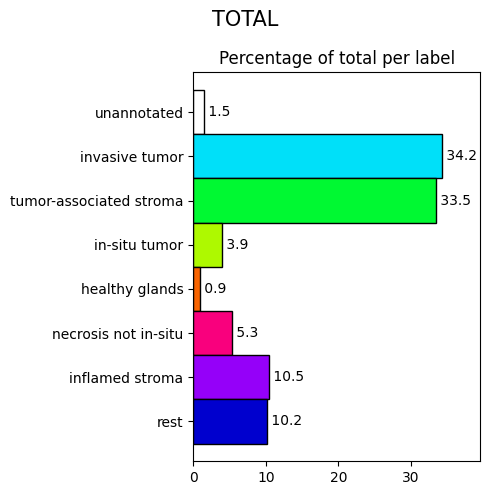

In [188]:
counts_total = df_counts[label_names].sum()
plot_percentages(counts_total, "TOTAL")

# Split

In [189]:
from sklearn.model_selection import KFold

In [190]:
def plot_train_val_fold_counts(counts_train, counts_val, title, label_names=label_names):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title, fontsize=15)
    for i_counts, counts in enumerate([counts_train, counts_val]):
        bar_list = axs[i_counts].barh(label_names, counts, height=1) #, height=0.95, log=True)
        for i_bar, bar in enumerate(bar_list):
            bar.set_color(cmap(label_index[i_bar]))
            bar.set_edgecolor("black")
        axs[i_counts].invert_yaxis()
        axs[i_counts].set_title(f"{'TRAIN - ' if i_counts == 0 else 'VAL - '}Pixels per label total (x 100 000)")
        n = len(label_names)
        for i_label in range(n):
            axs[i_counts].text(counts[i_label], i_label, s=" " + str(round(counts[i_label]/100000, 2)) if counts[i_label] !=0.0 else "", 
                     ha="left", va="center")
        axs[i_counts].set_xlim(0, axs[i_counts].get_xlim()[1] + axs[i_counts].get_xlim()[1]*0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

In [191]:
import torch

In [192]:
def array_to_formatted_tensor(array):
    tens = torch.tensor(np.array([array]))
    return tens

In [193]:
def counts_list_and_mean_to_loss(counts_list, counts_mean, log=False):
    loss = torch.nn.MSELoss(reduction='none')
    loss_per_fold_list = []
    for counts in counts_list:
        loss_per_fold = loss(array_to_formatted_tensor(counts), 
                             array_to_formatted_tensor(counts_mean))
        if log:         
            loss_per_fold_list.append(np.log10(loss_per_fold + 0.00000001))
        else:
            loss_per_fold_list.append(loss_per_fold)
        # print(np.log(loss_per_fold))
    # print(loss_per_fold_list)
    mean_loss = torch.cat(loss_per_fold_list).mean()
    # mean_loss = np.mean(loss_per_fold_list)
    return mean_loss

In [194]:
def print_best_dist_loss(dist_losses):
    idx = dist_losses.index(min(dist_losses))
    print(idx, ':', dist_losses[idx])

In [195]:
# train_distribution_losses

### Claculate the mean MSE losses over percentages of indivudual folds and their mean

In [196]:
wsi_or_roi_based = 'wsi'

## WSI based

In [197]:
if wsi_or_roi_based == 'wsi':
    # important_classes = ['Tumor',
    #                      'Healthy stroma',
    #                      'Tumor-associated stroma',
    #                      'Inflammation',
    #                      'Necrotic tissue'
    #                     ]
    important_classes = label_names[1:]

    percentages = True

    train_distribution_losses = []
    train_distribution_losses_log = []
    val_distribution_losses = []
    val_distribution_losses_log = []
    for i in range(500):
        random_state= i

        df_wsi_counts['val_fold'] = [None]*len(df_wsi_counts)
        folds=5
        fold_splits = {}

        k5 = KFold(n_splits=folds, shuffle=True, random_state=i) 
        for fold, indexes in enumerate(k5.split(df_wsi_counts['wsi'])):
            fold_splits[fold] = indexes 
            df_wsi_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
        train_counts_list = []
        val_counts_list = []
        for fold in range(folds):
            counts_train = list(df_wsi_counts.loc[fold_splits[fold][0], important_classes].sum())
            if percentages == True:
                counts_train = np.array(counts_train)/sum(counts_train)
            train_counts_list.append(counts_train)
            counts_val = list(df_wsi_counts.loc[fold_splits[fold][1], important_classes].sum())
            if percentages == True:
                counts_val = np.array(counts_val)/sum(counts_val)
            val_counts_list.append(counts_val)
            # title = f'Fold {fold}'
            # plot_train_val_fold_counts(counts_train, counts_val, title)

        train_counts_mean = np.mean(train_counts_list, 0)
        train_distribution_loss = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean)
        train_distribution_losses.append(float(train_distribution_loss))
        train_distribution_loss_log = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean, log=True)
        train_distribution_losses_log.append(float(train_distribution_loss_log))

        val_counts_mean = np.mean(val_counts_list, 0)
        val_distribution_loss = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean)
        val_distribution_losses.append(float(val_distribution_loss))
        val_distribution_loss_log = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean, log=True)
        val_distribution_losses_log.append(float(val_distribution_loss_log))

In [198]:
if wsi_or_roi_based == 'wsi':
    print_best_dist_loss(train_distribution_losses)
    print_best_dist_loss(train_distribution_losses_log)

416 : 7.1862755077145895e-06
125 : -5.8617683710337305


In [199]:
if wsi_or_roi_based == 'wsi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

144 : 0.00011275217712732525
125 : -4.732274115954272


In [200]:
if wsi_or_roi_based == 'roi':
    # important_classes = ['Tumor',
    #                      'Healthy stroma',
    #                      'Tumor-associated stroma',
    #                      'Inflammation',
    #                      'Necrotic tissue'
    #                     ]
    important_classes = label_names

    percentages = True

    train_distribution_losses = []
    train_distribution_losses_log = []
    val_distribution_losses = []
    val_distribution_losses_log = []
    for i in range(500):
        random_state= i

        df_counts['val_fold'] = [None]*len(df_counts)
        folds=5
        fold_splits = {}

        k5 = KFold(n_splits=folds, shuffle=True, random_state=i) 
        for fold, indexes in enumerate(k5.split(df_counts['wsi_roi_stem'])):
            fold_splits[fold] = indexes 
            df_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
        train_counts_list = []
        val_counts_list = []
        for fold in range(folds):
            counts_train = list(df_counts.loc[fold_splits[fold][0], important_classes].sum())
            if percentages == True:
                counts_train = np.array(counts_train)/sum(counts_train)
            train_counts_list.append(counts_train)
            counts_val = list(df_counts.loc[fold_splits[fold][1], important_classes].sum())
            if percentages == True:
                counts_val = np.array(counts_val)/sum(counts_val)
            val_counts_list.append(counts_val)
            # title = f'Fold {fold}'
            # plot_train_val_fold_counts(counts_train, counts_val, title)

        train_counts_mean = np.mean(train_counts_list, 0)
        train_distribution_loss = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean)
        train_distribution_losses.append(float(train_distribution_loss))
        train_distribution_loss_log = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean, log=True)
        train_distribution_losses_log.append(float(train_distribution_loss_log))

        val_counts_mean = np.mean(val_counts_list, 0)
        val_distribution_loss = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean)
        val_distribution_losses.append(float(val_distribution_loss))
        val_distribution_loss_log = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean, log=True)
        val_distribution_losses_log.append(float(val_distribution_loss_log))

In [201]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(train_distribution_losses)
    print_best_dist_loss(train_distribution_losses_log)

In [202]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

## WSI based split

In [203]:
random_state= 416 

[  5   9  10  12  32  34  38  42  51  55  57  59  61  67  73  75  77  81
  85  86  96 108 111 115 127 143 146 147 148 150 151 160 170 172 183 184
 187 189 191]


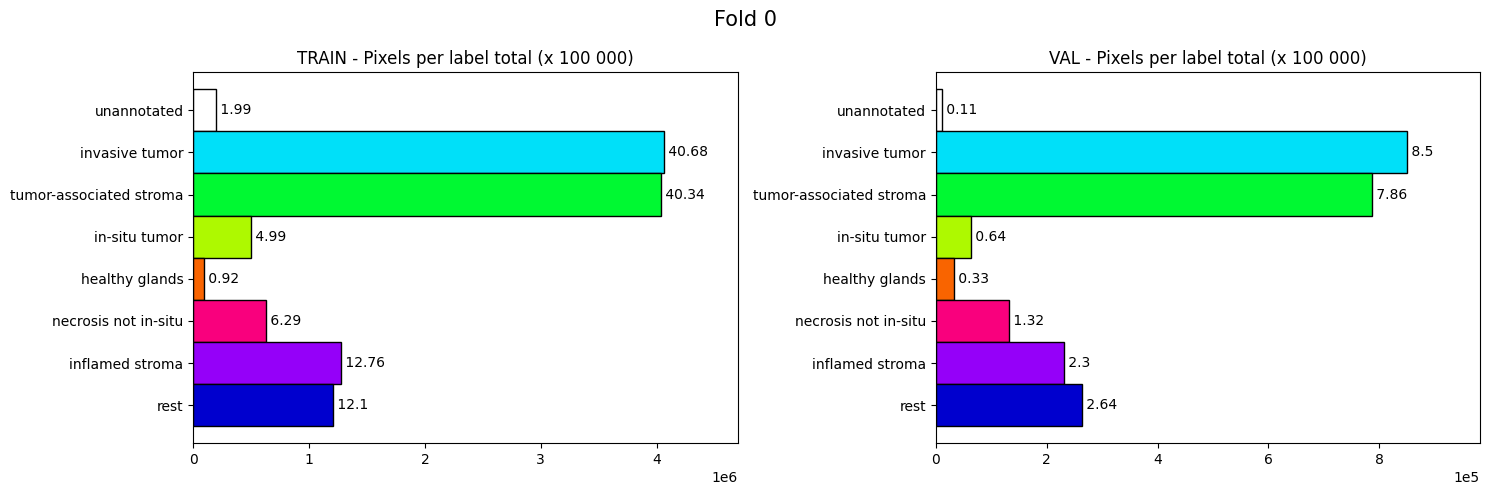

[  7   8  14  23  26  30  33  36  39  40  41  45  53  68  74  89  92  99
 104 105 110 112 113 114 124 126 130 134 141 142 152 155 167 180 182 185
 188 190 192]


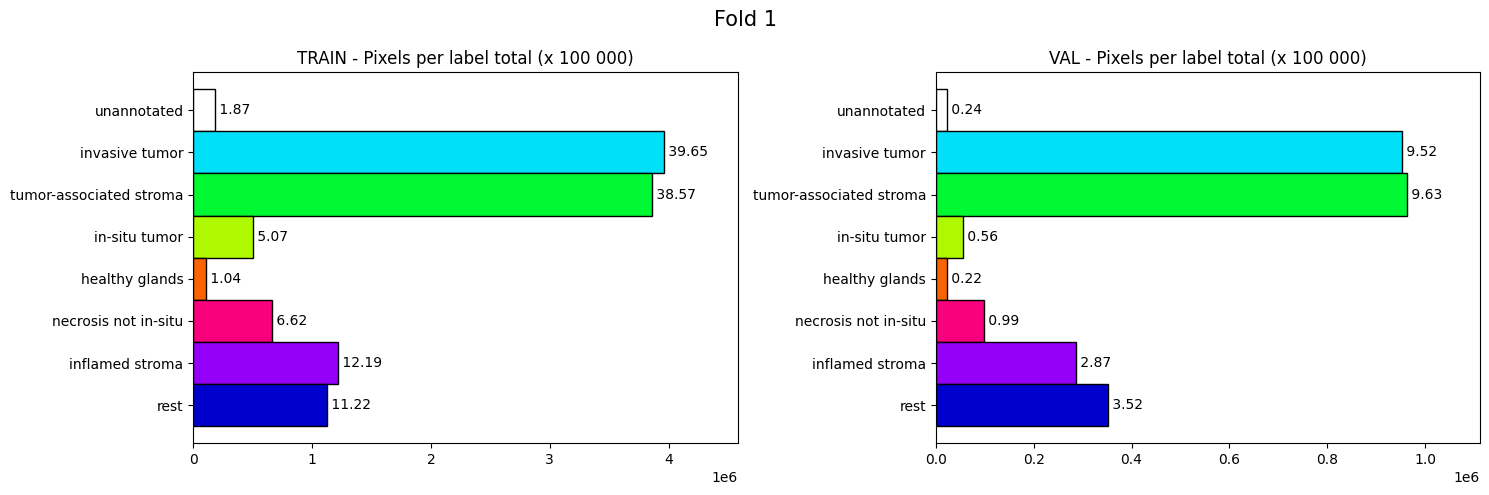

[  0   1   2   3  13  16  22  25  49  50  52  54  56  58  66  71  72  76
  78  84  87  95 100 101 106 109 116 125 128 135 136 156 157 158 162 165
 169 174 176]


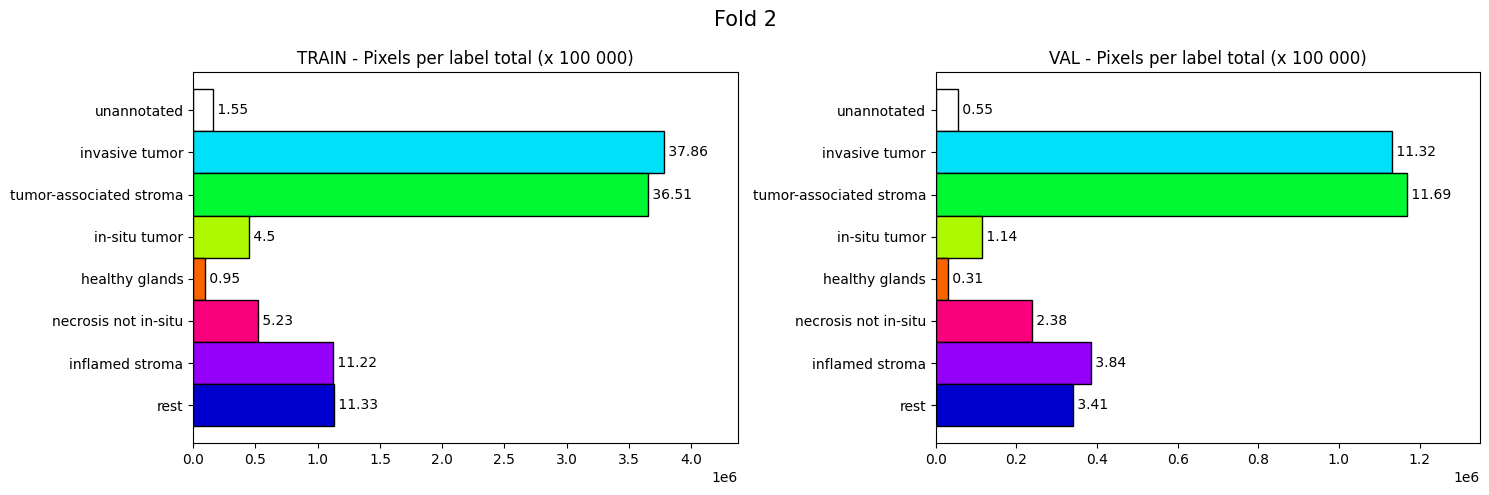

[  4  11  17  19  21  24  27  35  37  44  48  62  63  64  69  70  79  80
  82  88  90  97 103 107 118 120 121 138 139 140 153 161 163 166 168 173
 175 177 194]


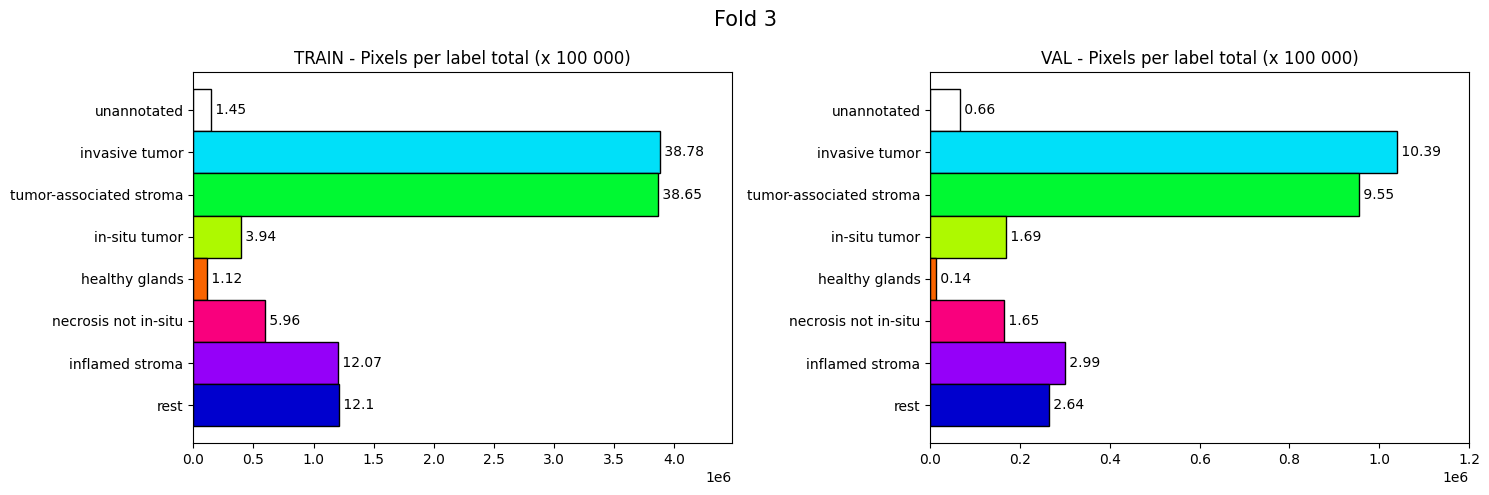

[  6  15  18  20  28  29  31  43  46  47  60  65  83  91  93  94  98 102
 117 119 122 123 129 131 132 133 137 144 145 149 154 159 164 171 178 179
 181 186 193]


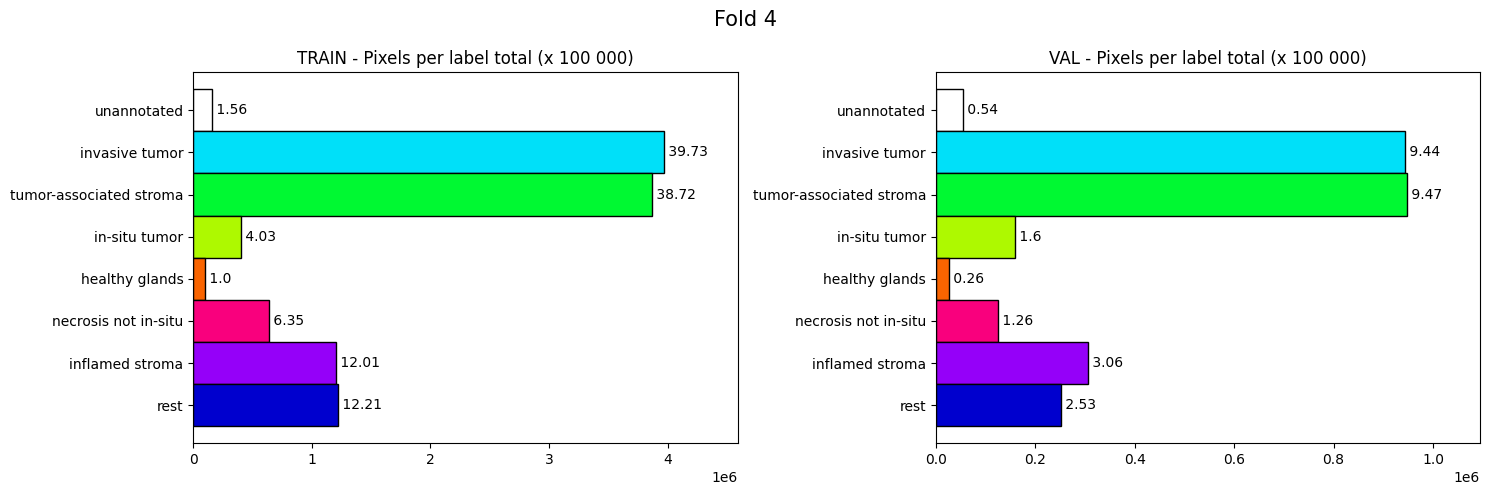

In [204]:
if wsi_or_roi_based == 'wsi':
    important_classes=label_names
    df_wsi_counts['val_fold'] = [None]*len(df_wsi_counts)
    folds=5
    fold_splits = {}

    k5 = KFold(n_splits=folds, shuffle=True, random_state=random_state) 
    for fold, indexes in enumerate(k5.split(df_wsi_counts['wsi'])):
        fold_splits[fold] = indexes 
        df_wsi_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
    train_counts_list = []
    val_counts_list = []
    for fold in range(folds):
        print(fold_splits[fold][1])
        counts_train = list(df_wsi_counts.loc[fold_splits[fold][0], important_classes].sum())
        train_counts_list.append(counts_train)
        counts_val = list(df_wsi_counts.loc[fold_splits[fold][1], important_classes].sum())
        val_counts_list.append(counts_val)
        title = f'Fold {fold}'
        plot_train_val_fold_counts(counts_train, counts_val, title, label_names=important_classes)

## ROI based split

In [413]:
if wsi_or_roi_based == 'roi':
    random_state= 367     

In [414]:
if wsi_or_roi_based == 'roi':
    important_classes=label_names

    df_counts['val_fold'] = [None]*len(df_counts)

    folds=5
    fold_splits = {}

    k5 = KFold(n_splits=folds, shuffle=True, random_state=random_state) 
    for fold, indexes in enumerate(k5.split(df_counts['wsi_roi_stem'])):
        fold_splits[fold] = indexes 
        df_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
    train_counts_list = []
    val_counts_list = []
    for fold in range(folds):
        counts_train = list(df_counts.loc[fold_splits[fold][0], important_classes].sum())
        train_counts_list.append(counts_train)
        counts_val = list(df_counts.loc[fold_splits[fold][1], important_classes].sum())
        val_counts_list.append(counts_val)
        title = f'Fold {fold}'
        plot_train_val_fold_counts(counts_train, counts_val, title, label_names=important_classes)

# Prepare yamls

In [427]:
if wsi_or_roi_based == 'wsi':
    df_counts['val_fold'] = [None]*len(df_counts)
    for fold in range(folds):
        val = list(df_wsi_counts[df_wsi_counts['val_fold']==fold]['wsi'])
        idx = df_counts[df_counts['wsi'].isin(val)].index
        df_counts.loc[idx, 'val_fold'] = fold

In [428]:
df_counts

,wsi,roi,unannotated,invasive tumor,tumor-associated stroma,in-situ tumor,healthy glands,necrosis not in-situ,inflamed stroma,rest,wsi_roi_stem,val_fold
0,100B,0,11621,0,0,0,824601,0,0,821497,100B_ROI0,3
1,100B,1,2962,916850,608288,0,0,0,0,0,100B_ROI1,3
2,100B,2,2489,0,0,0,48616,0,0,1495895,100B_ROI2,3
3,114S,0,8968,577989,323926,0,93944,0,82968,338223,114S_ROI0,1
4,114S,1,9110,579051,649181,0,0,0,63386,0,114S_ROI1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
281,TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...,0,2024123,1047780,947174,0,0,0,820219,0,TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...,4
282,TCGA-OL-A6VO-01Z-00-DX1.291D54D6-EBAF-4622-BD4...,0,966038,420983,306976,0,0,0,92212,19766,TCGA-OL-A6VO-01Z-00-DX1.291D54D6-EBAF-4622-BD4...,3
283,TCGA-OL-A97C-01Z-00-DX1.BDEEDEE2-6D07-4046-A8A...,0,3571024,990610,2410089,0,0,0,0,635635,TCGA-OL-A97C-01Z-00-DX1.BDEEDEE2-6D07-4046-A8A...,3
284,TCGA-S3-AA10-01Z-00-DX1.C0468882-0DD8-4FC5-8C2...,0,1703471,888257,686829,0,0,148183,139648,133444,TCGA-S3-AA10-01Z-00-DX1.C0468882-0DD8-4FC5-8C2...,3


In [429]:
if wsi_or_roi_based == 'roi':
    df_counts['val_fold'] = [None]*len(df_counts)
    for fold in range(folds):
        idx = fold_splits[fold][1]
        df_counts.loc[idx, 'val_fold'] = fold

In [430]:
from collections import OrderedDict
if wsi_or_roi_based == 'wsi' or 'roi':
    data_split_json = []
    for fold in range(folds):
        val = list(df_counts[df_counts['val_fold']==fold]['roi'])
        train = list(df_counts[df_counts['val_fold']!=fold]['roi'])
        data_split_json.append(OrderedDict(train=train, val=val))
    # data_split_json

In [436]:
data_split_json[0]['train']

[0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# DATALOADER

In [25]:
%%yaml user_config  

wholeslidedata:
    default:
        # Source to data
        yaml_source: example_files
        
        # Set image backend to asap
        image_backend: asap
                
        # Labels and their value in mask
        labels:
            invasive tumor: 1
            tumor-associated stroma: 2
            in-situ tumor: 3
            healthy glands: 4
            necrosis not in-situ: 5
            inflamed stroma: 6
            rest: 7
            
        # Sort annotations by area (this is how TIGER data is annotated)
        annotation_parser:
            sorters: 
                - ${$wholeslidedata.annotation.selector.sort_by_area_with_roi}
        
        # Batch shape
        batch_shape:
            batch_size: 8
            spacing: 1.0
            shape: [512,512,3]
    
        # Automatically copy files to /home/user/data
        dataset:
            copy_path: 'C:\Users\joeyspronck\Documents\Github\nnUNet_v2\data\nnUNet_wsd' #/home/user/data
    
        # Change labels sampler to WeightedLabelSampler
        label_sampler_name: WeightedLabelSampler
        # The WeightedLabelSampler needs a weight for each label, all weights should sum to 1
        label_sampler:
            labels: 
                invasive tumor: 0.5
                tumor-associated stroma: 0.5
                # in-situ tumor: 0.25
                # healthy glands: 0.05
                # necrosis not in-situ: 0.05
                # inflamed stroma: 0.05
                # rest: 0.35
        
        # Change annotation sampler to AreaAnnotationSampler
        annotation_sampler_name: AreaAnnotationSampler
        # AreaAnnotationSampler, additional needs the dataset as a dependency
        annotation_sampler:
            dataset: ${dataset}
            weight: 0.5  # smooth sampling such that small annotations will be sampled sometimes
        

        batch_callbacks: 
            "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
            sizes: [[256,256], [128,128]]

In [26]:
%%yaml user_config_template  

wholeslidedata:
    default:
        # Source to data
        yaml_source: ''
        
        # Set image backend to asap
        image_backend: asap
                
        # Labels and their value in mask
        labels:
            ''
            
        # Sort annotations by area (this is how TIGER data is annotated)
        annotation_parser:
            sorters: 
                - ${$wholeslidedata.annotation.selector.sort_by_area_with_roi}
        
        # Batch shape
        batch_shape:
            batch_size: ''
            spacing: ''
            shape: ''
    
        # Automatically copy files to /home/user/data
        dataset:
            copy_path: '' #'C:\Users\joeyspronck\Documents\Github\nnUNet_v2\data\nnUNet_wsd' #/home/user/data
    
        # Change labels sampler to WeightedLabelSampler
        label_sampler_name: WeightedLabelSampler
        # The WeightedLabelSampler needs a weight for each label, all weights should sum to 1
        label_sampler:
            labels: 
#                 invasive tumor: 0.5
#                 tumor-associated stroma: 0.5
                # in-situ tumor: 0.25
                # healthy glands: 0.05
                # necrosis not in-situ: 0.05
                # inflamed stroma: 0.05
                # rest: 0.35
                ''
        
        # Change annotation sampler to AreaAnnotationSampler
        annotation_sampler_name: AreaAnnotationSampler
        # AreaAnnotationSampler, additional needs the dataset as a dependency
        annotation_sampler:
            dataset: ${dataset}
            weight: 0.5  # smooth sampling such that small annotations will be sampled sometimes
        

        batch_callbacks: 
            -   "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
                sizes: []

### Display user_config

In [27]:
user_config

{'wholeslidedata': {'default': {'yaml_source': 'example_files',
   'image_backend': 'asap',
   'labels': {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7},
   'annotation_parser': {'sorters': ['${$wholeslidedata.annotation.selector.sort_by_area_with_roi}']},
   'batch_shape': {'batch_size': 8, 'spacing': 1.0, 'shape': [512, 512, 3]},
   'dataset': {'copy_path': 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'},
   'label_sampler_name': 'WeightedLabelSampler',
   'label_sampler': {'labels': {'invasive tumor': 0.5,
     'tumor-associated stroma': 0.5}},
   'annotation_sampler_name': 'AreaAnnotationSampler',
   'annotation_sampler': {'dataset': '${dataset}', 'weight': 0.5},
   'batch_callbacks': {'*object': 'wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback',
    'sizes': [[256, 256], [128, 128]]}}}}

In [55]:
user_config_template

{'wholeslidedata': {'default': {'yaml_source': {'training': [{'wsa': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7B80>}, 'wsi': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C78E0>}}, {'wsa': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7C40>}, 'wsi': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7D30>}}, {'wsa': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7DF0>}, 'wsi': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7EB0>}}, {'wsa': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C7FD0>}, 'wsi': {'path': <dicfg.config.ConfigValue object at 0x000001A8EB7C5160>}}]}, 'image_backend': <dicfg.config.ConfigValue object at 0x000001A8EB7C7850>, 'labels': {'invasive tumor': <dicfg.config.ConfigValue object at 0x000001A8EB7C52B0>, 'tumor-associated stroma': <dicfg.config.ConfigValue object at 0x000001A8EB7C51F0>, 'in-situ tumor': <dicfg.config.ConfigValue object at 0x000001A8EB7C5310>, 'healthy glands': <

In [29]:
import json
with open('plain_wsd_dataloader.json', 'w') as f:
    json.dump(user_config_template, f, indent=4)

In [30]:
labels

{'invasive tumor': 1,
 'tumor-associated stroma': 2,
 'in-situ tumor': 3,
 'healthy glands': 4,
 'necrosis not in-situ': 5,
 'inflamed stroma': 6,
 'rest': 7}

In [31]:
yaml_source = example_files
labels = {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7}
batch_size = 15
patch_size = [512, 512]
patch_shape = [512, 512, 3]
spacing = 0.5
label_sample_weights = {
    'invasive tumor': 0.5,
    'tumor-associated stroma': 0.5
}
ds_scales = [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125], [0.015625, 0.015625]]
ds_shapes = [list(np.round([int(i * j) for i, j in zip(patch_size, k)])) for k in ds_scales]
extra_ds_sizes = [ds_shape for ds_shape in ds_shapes[1:]]
extra_ds_shapes = tuple([tuple([batch_size]+ds_shape) for ds_shape in ds_shapes[1:]])

In [32]:
yaml_source

{'training': [{'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\100B.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\100B.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\114S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\114S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\122S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\122S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\133S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\w

In [33]:
fill_template = user_config_template['wholeslidedata']['default']

fill_template['yaml_source'] = yaml_source
fill_template['labels'] = labels
fill_template['batch_shape']['batch_size'] = batch_size
fill_template['batch_shape']['spacing'] = spacing
fill_template['batch_shape']['shape'] = patch_shape
fill_template['label_sampler']['labels'] = label_sample_weights
fill_template['batch_callbacks'][-1]['sizes'] = extra_ds_sizes
fill_template['dataset']['copy_path'] = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'

In [34]:
user_config_template

{'wholeslidedata': {'default': {'yaml_source': {'training': [{'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\100B.xml'},
      'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\100B.tif'}},
     {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\114S.xml'},
      'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\114S.tif'}},
     {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\122S.xml'},
      'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\122S.tif'}},
     {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\133S.xml'},
  

## 2. **Batch Iterator**

- First time calling create_batch_iterator will copy all the images and annotations. This can take a while when using the full tiger training dataset.
- Second time calling create_batch_iterator will skip copying as it will already find the local files.
- Each time calling create_batch_iterator will initialize the TIGER training dataset; this can take up to 2 minutes when using the full tiger training dataset.

In [38]:
cpus = 4
tiger_batch_iterator = create_batch_iterator(mode="training", 
                                             user_config=user_config_template, 
                                             cpus=cpus, 
                                             buffer_dtype='uint8',
                                             context='spawn' if current_os == 'w' else 'fork',
                                             extras_shapes = extra_ds_shapes,
#                                              iterator_class=WholeSlidePlainnnUnetBatchIterator
                                            )

### Plot batches

In [39]:
x_batch, y_batch, *extras, info =  next(tiger_batch_iterator)

ValueError: not enough values to unpack (expected at least 3, got 2)

## 2.1 nnUNet wrapper 

In [43]:
from wholeslidedata.iterators.batchiterator import BatchIterator

class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
    def __next__(self):
        x_batch, y_batch, *extras, _ = super().__next__()
        data = x_batch.transpose(0,3,1,2).astype('float32')
        target = [np.expand_dims(y_batch, 1).astype('int16')] + [np.expand_dims(extra, 1).astype('int16') for extra in extras]         
        return {'data': data, 'target': target}

In [44]:
cpus = 4
tiger_batch_iterator = create_batch_iterator(mode="training", 
                                             user_config=user_config_template, 
                                             cpus=cpus, 
                                             buffer_dtype='uint8',
                                             context='spawn' if current_os == 'w' else 'fork',
                                             extras_shapes = extra_ds_shapes,
                                             iterator_class=WholeSlidePlainnnUnetBatchIterator
                                            )

In [46]:
batch =  next(tiger_batch_iterator)

In [49]:
batch['target'][0]

array([[[[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]],


       [[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]],


       [[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 2, 2, 2],
         [0, 0, 0, ..., 2, 2, 2],
         [0, 0, 0, ..., 2, 2, 2]]],


       ...,


       [[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 

In [24]:
print(type(extras))
for extra in extras:
    print(extra.shape)

<class 'list'>
(15, 256, 256)
(15, 128, 128)
(15, 64, 64)
(15, 32, 32)
(15, 16, 16)
(15, 8, 8)


In [25]:
x_batch = x_batch.transpose(0,3,1,2).astype('float32')
y_batch = [np.expand_dims(y_batch, 1).astype('int16')] + [np.expand_dims(extra, 1) for extra in extras]

In [26]:
for y in y_batch:
    print(y.shape)

(15, 1, 512, 512)
(15, 1, 256, 256)
(15, 1, 128, 128)
(15, 1, 64, 64)
(15, 1, 32, 32)
(15, 1, 16, 16)
(15, 1, 8, 8)


In [27]:
x_batch.shape

(15, 3, 512, 512)

In [28]:
x_batch_t = x_batch.transpose(0,3,1,2).astype('float32')
x_batch_t.shape

(15, 512, 3, 512)

In [29]:
y_batch = y_batch.astype('int16')
np.expand_dims(y_batch, 1).shape

AttributeError: 'list' object has no attribute 'astype'

In [37]:
from wholeslidedata.iterators.batchiterator import BatchIterator

class WholeSlidePlainnnUnetBatchIterator(BatchIterator):
    def __next__(self):
        x_batch, y_batch, *extras, _ = super().__next__()
        data = x_batch.transpose(0,3,1,2).astype('float32')
        target = [np.expand_dims(y_batch, 1).astype('int16')] + [np.expand_dims(extra, 1).astype('int16') for extra in extras]         
        return {'data': data, 'target': target}

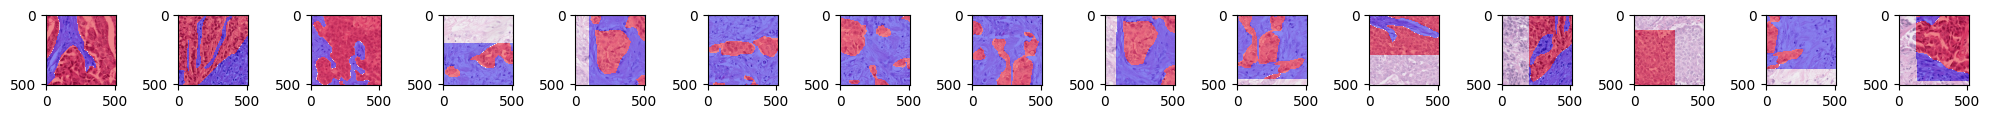

In [18]:
plot_batch(x_batch, y_batch)

In [19]:
extra

array([[[1, 1, 2, 2, 1, 1, 1, 1],
        [1, 1, 2, 2, 1, 1, 1, 1],
        [1, 1, 2, 2, 1, 1, 1, 1],
        [1, 1, 2, 2, 2, 1, 1, 1],
        [1, 2, 2, 1, 2, 1, 1, 1],
        [1, 2, 1, 1, 1, 2, 1, 1],
        [2, 2, 1, 1, 1, 1, 1, 1],
        [2, 2, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 2, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 2, 1, 1],
        [1, 1, 1, 1, 1, 2, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 2],
        [1, 2, 1, 1, 2, 1, 2, 2],
        [1, 1, 2, 2, 1, 2, 2, 2],
        [2, 1, 1, 1, 2, 2, 2, 2]],

       [[2, 2, 1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 1, 1, 2, 2, 1],
        [2, 1, 2, 1, 1, 1, 2, 1],
        [2, 1, 1, 1, 1, 2, 1, 1],
        [2, 1, 1, 1, 1, 2, 1, 1]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 1, 1, 1],
        

In [ ]:
plot_batch()

# BELOW IS OLD NOW

In [13]:
import numpy as np
import torch
from skimage.transform import resize
import matplotlib.pyplot as plt

#### Dummy example

In [15]:
batch_size = 2
patch_size = [512, 512]
device = torch.device('cuda')
dummy_data = torch.rand((batch_size, 3, *patch_size), device=device)
dummy_target = [
    torch.round(
        torch.rand((batch_size, 1, *[int(i * j) for i, j in zip(patch_size, k)]), device=device) *
        max(all_labels)
    ) for k in deep_supervision_scales]

In [16]:
dummy_data.shape

torch.Size([2, 3, 512, 512])

In [17]:
for i in dummy_target:
    print(i.shape)

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 128, 128])
torch.Size([2, 1, 64, 64])
torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 16, 16])


#### How to get the deep supervision shapes

#### Resize example

In [78]:
def resize_segmentation(segmentation, new_shape, order=3):
    '''
    Resizes a segmentation map. Supports all orders (see skimage documentation). Will transform segmentation map to one
    hot encoding which is resized and transformed back to a segmentation map.
    This prevents interpolation artifacts ([0, 0, 2] -> [0, 1, 2])
    :param segmentation:
    :param new_shape:
    :param order:
    :return:
    '''
    tpe = segmentation.dtype
    unique_labels = np.unique(segmentation)
    assert len(segmentation.shape) == len(new_shape), "new shape must have same dimensionality as segmentation"
    if order == 0:
        return resize(segmentation.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False).astype(tpe)
    else:
        reshaped = np.zeros(new_shape, dtype=segmentation.dtype)

        for i, c in enumerate(unique_labels):
            mask = segmentation == c
            reshaped_multihot = resize(mask.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False)
            reshaped[reshaped_multihot >= 0.5] = c
        return reshaped

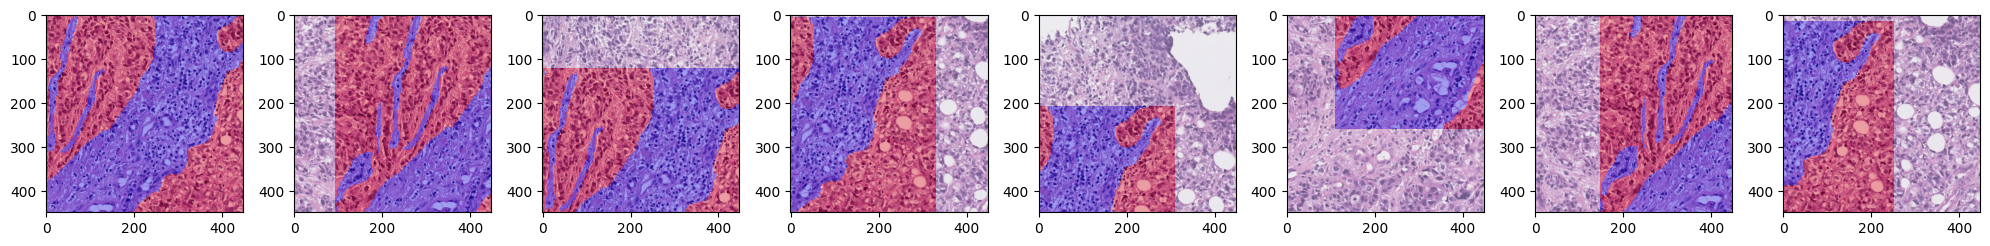

In [126]:
x_batch, y_batch, info =  next(tiger_batch_iterator)
plot_batch(x_batch, y_batch, alpha=0.3)

In [ ]:
import timeit

[8, 448, 448]


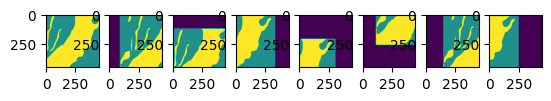


[8, 224, 224]


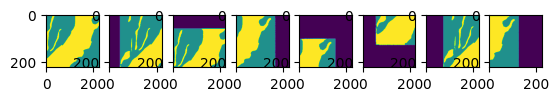


[8, 112, 112]


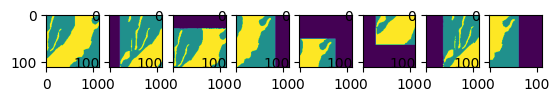


[8, 56, 56]


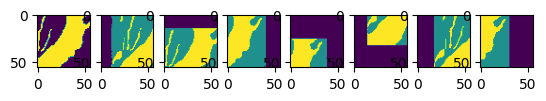


[8, 28, 28]


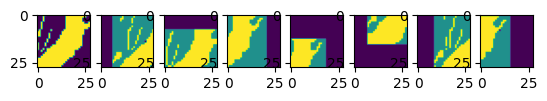


[8, 14, 14]


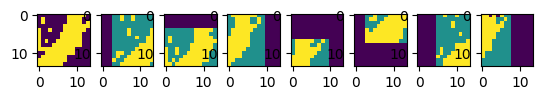

In [156]:
bs = y_batch.shape[0]
for ds_shape in ds_shapes:
    resized_batch = resize_segmentation(y_batch, [bs] + ds_shape)
    print([bs] + ds_shape)
    
    fig, axs = plt.subplots(1, bs)
    for i in range(bs):
        axs[i].imshow(resized_batch[i])
    plt.show()
    print()

In [158]:
ds_shapes

[[448, 448], [224, 224], [112, 112], [56, 56], [28, 28], [14, 14]]

In [159]:
import time

start_time = time.time()

for ds_shape in ds_shapes:
    resized_batch = resize_segmentation(y_batch, [bs] + ds_shape)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 5.7554 seconds


In [160]:
import time

start_time = time.time()

resized_batches = [resize_segmentation(y_batch, [bs] + ds_shape) for ds_shape in ds_shapes]

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 5.7672 seconds


In [130]:
resized_batch.shape

(8, 56, 56)

## Stop the iterator to free up all memory

In [130]:
tiger_batch_iterator.stop()

## 3. **WholeSlidePlainnnUnetBatchIterator**

The WholeSlidennUnetBatchIterator is a wrapper around the default Batchiterator, it does the following things:

- tranpose x_batch to channels first
- convert dtype of x_batch to float32
- convert dtype of y_batch to int16
- returns dictionary with keys: 'data', 'target'  for x_batch and y_batch, respectively

In [8]:
cpus = 4
nnunet_tiger_batch_iterator = create_batch_iterator(mode="training", 
                                                    user_config=user_config, 
                                                    cpus=cpus, 
                                                    buffer_dtype='uint8', 
                                                    iterator_class=WholeSlidePlainnnUnetBatchIterator) # here we can set the WholeSlidennUnetBatchIterator wrapper 

In [9]:
# get next batch for training nnunet
batch = next(nnunet_tiger_batch_iterator)
data = batch['data']
target = batch['seg_all']

# check shape and dtypes
print('data:\t', data.shape, data.dtype)
print('target:\t', target.shape, target.dtype)

data:	 (8, 3, 512, 512) float32
target:	 (8, 512, 512) int16


In [10]:
nnunet_tiger_batch_iterator.stop()

## **(NOT TESTED) Proposal implementation BatchIterator in nnUNetTrainer**

I think there are two ways of implementing the WholeSlideData batchiterator in the nnUnet pipeline.

1. overriding the 'get_plain_dataloaders' method
2. overriding the 'get_dataloaders' method

### 1. Overriding the 'get_plain_dataloaders' method
This has the advantageous that (I think) it works out of the box and an example implementation is shown below. However I have not tested it and I might have missed something. The downside is that both nnUnet as well as the batchiterator utilizes multiprocessing. This however might not be a problem if you divide cpus between the batchiterator and nnunet pipeline, e.g., 6 to the iterator and 6 for the nnunet pipeline.

In [15]:
class WholeSlidennUNetTrainer(nnUNetTrainer):
    def __init__(self, 
                 plans: dict, 
                 configuration: str, 
                 fold: int, 
                 dataset_json: dict, 
                 iterator_config: Union[str, path, dict],
                 iterator_cpus: int,
                 unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        
        self._iterator_config = iterator_config
        self._iterator_cpus = iterator_cpus
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        
        
    def get_plain_dataloaders(self):
        dl_tr = create_batch_iterator(mode="training", 
                                      user_config=self._iterator_config, 
                                      cpus=self._iterator_cpus, 
                                      buffer_dtype='uint8', 
                                      iterator_class=WholeSlidePlainnnUnetBatchIterator) 
        
        dl_val = create_batch_iterator(mode="validation",
                                       user_config=self._iterator_config, 
                                       cpus=self._iterator_cpus, 
                                       buffer_dtype='uint8', 
                                       iterator_class=WholeSlidePlainnnUnetBatchIterator) 
        return dl_tr, dl_val

NameError: name 'nnUNetTrainer' is not defined

### 2. Overriding the 'get_dataloaders' method
This has the advantageous that all multiprocessing can be done via the BatchIterator. The downside is that some essential transforms, e.g., DownsampleSegForDSTransform2 for deep supervision should be done via batch callbacks in the BatchIterator. This can be done, but is not super straightforward and I have not made an example for this (yet).

# Recreate the init in the train loop

In [1]:
import torch
from nnunetv2.training.nnUNetTrainer.variants.pathology.nnUNetTrainer_custom_dataloader_test import nnUNetTrainer_custom_dataloader_test 
from batchgenerators.utilities.file_and_folder_operations import join, isfile, load_json

In [2]:
plans_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset001_local_test\\nnUNetPlans.json'
configuration = '2d'
fold = 0
dataset_json_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset001_local_test\\dataset.json'
use_compressed = False
device = torch.device('cuda')

plans = load_json(plans_file)
dataset_json = load_json(dataset_json_file)

### Below I proved the default plans file works

In [3]:
# nnunet_trainer = nnUNetTrainer_custom_dataloader_test
# nnunet_trainer = nnunet_trainer(plans=plans, configuration=configuration, fold=fold,
#                                 dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

In [4]:
# nnunet_trainer.run_training()

# Now remove as much as possible from plans

In [2]:
# plans

In [22]:
dataset_json

{'channel_names': {'0': 'rgb_to_0_1', '1': 'rgb_to_0_1', '2': 'rgb_to_0_1'},
 'labels': {'background': 0,
  'tumor': 1,
  'none': 2,
  'stroma': 3,
  'inflammation': 4,
  'healthy parenchyma': 5,
  'fatty tissue': 6,
  'necrotic tissue': 7,
  'erytrocytes': 8,
  'healthy epithelium': 9,
  'mucus': 10,
  'cartilage': 11,
  'macrophages': 12,
  'other': 13},
 'numTraining': 163,
 'file_ending': '.png'}

In [21]:
plans_essential = {
    # plans_name
    'plans_name': 'nnUNetPlans',
    # dataset_name
    'dataset_name': 'Dataset002_plain_test', # only needed for name of output folder
    # configurations
    'configurations': {'2d': {'data_identifier': 'nnUNetPlans_2d',
    'preprocessor_name': 'DefaultPreprocessor',
    'batch_size': 16,
    'patch_size': [448, 448],
#     'median_image_size_in_voxels': [1022.0, 1032.0],
#     'spacing': [1.0, 1.0],
    'normalization_schemes': ['RGBTo01Normalization',
    'RGBTo01Normalization',
    'RGBTo01Normalization'],
#     'use_mask_for_norm': [False, False, False],
    'UNet_class_name': 'PlainConvUNet',
    'UNet_base_num_features': 32,
    'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2, 2],
    'n_conv_per_stage_decoder': [2, 2, 2, 2, 2, 2],
    'num_pool_per_axis': [6, 6],
    'pool_op_kernel_sizes': [[1, 1],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2]],
    'conv_kernel_sizes': [[3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3]],
    'unet_max_num_features': 512,
#     'resampling_fn_data': 'resample_data_or_seg_to_shape',
#     'resampling_fn_seg': 'resample_data_or_seg_to_shape',
#     'resampling_fn_data_kwargs': {'is_seg': False,
#     'order': 3,
#     'order_z': 0,
#     'force_separate_z': None},
#     'resampling_fn_seg_kwargs': {'is_seg': True,
#     'order': 1,
#     'order_z': 0,
#     'force_separate_z': None},
#     'resampling_fn_probabilities': 'resample_data_or_seg_to_shape',
#     'resampling_fn_probabilities_kwargs': {'is_seg': False,
#     'order': 1,
#     'order_z': 0,
#     'force_separate_z': None},
    'batch_dice': True
                             }}
}

In [19]:
nnunet_trainer = nnUNetTrainer_custom_dataloader_test
nnunet_trainer = nnunet_trainer(plans=plans_essential, configuration=configuration, fold=fold,
                                dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

Using device: cuda:0
No label manager specified in plans. Using default: LabelManager

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Making summy data
	patch size: [448, 448]
	self.label_manager.all_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	self._get_deep_supervision_scales() [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125]]


In [16]:
nnunet_trainer.run_training()

# New experiment planner

In [5]:
plans_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset003_plain_experiment_planning\\nnUNetWholeSlideDataPlans.json'
configuration = '2d'
fold = 0
dataset_json_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset003_plain_experiment_planning\\dataset.json'
use_compressed = False
device = torch.device('cuda')

wsd_plans = load_json(plans_file)
dataset_json = load_json(dataset_json_file)

In [6]:
nnunet_trainer = nnUNetTrainer_custom_dataloader_test
nnunet_trainer = nnunet_trainer(plans=wsd_plans, configuration=configuration, fold=fold,
                                dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Making summy data
	patch size: [512, 512]
	self.label_manager.all_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	self._get_deep_supervision_scales() [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125], [0.015625, 0.015625]]


In [17]:
nnunet_trainer.run_training()


This is the configuration used by this training:
Configuration name: 2d
 {'data_identifier': 'nnUNetWholeSlideDataPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 15, 'patch_size': [512, 512], 'median_image_size_in_voxels': [1024, 1024], 'spacing': [1, 1], 'normalization_schemes': ['RGBTo01Normalization', 'RGBTo01Normalization', 'RGBTo01Normalization'], 'use_mask_for_norm': [False, False, False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2, 2, 2], 'num_pool_per_axis': [7, 7], 'pool_op_kernel_sizes': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'unet_max_num_features': 512, 'batch_dice': True} 

These are the global plan.json settings:
 {'dataset_name': 'Dataset003_plain_experiment_planning', 'plans_name': 'nnUNetWholeSlideDataPlans', 'image_r

# Make dummy batch

In [16]:
nnunet_trainer.dummy_batch['data'].shape

torch.Size([2, 3, 448, 448])

In [27]:
for i in range(6):
    print('ds', i, ':',  nnunet_trainer.dummy_batch['target'][i].shape)

ds 0 : torch.Size([2, 1, 448, 448])
ds 1 : torch.Size([2, 1, 224, 224])
ds 2 : torch.Size([2, 1, 112, 112])
ds 3 : torch.Size([2, 1, 56, 56])
ds 4 : torch.Size([2, 1, 28, 28])
ds 5 : torch.Size([2, 1, 14, 14])


In [59]:
import matplotlib.pyplot as plt

In [56]:
test = np.load('test.npy')

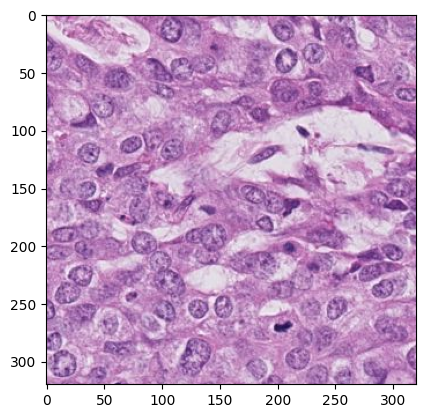

In [60]:
plt.imshow(test[0].transpose((1, 2, 0)))